In [3]:
import numpy as np
import helpers as hlp
import math
from random import random, seed
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from tqdm import tqdm


In [4]:
extracted_coefficients_path = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_path + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_path + 'beta/beta.csv')
z_path = str(extracted_coefficients_path + 'Bzeta/tr_labels.npy')

beta = np.genfromtxt(beta_path, delimiter=',')
# B_zeta is a n x q matrix
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
tBB = B_zeta.T.dot(B_zeta)
BoB = B_zeta**2
z = np.load(z_path) #[0:B_zeta.shape[0]]

# p is the number of beta coefficients in the last hidden layer
p = B_zeta.shape[1]

# Lambda is a diagonal matrix of dimension p
Lambda = np.random.rand(p,)

seed(679305)
tau_start = 0.01



# Set iteration counter to 0
t = 0


n = B_zeta.shape[0]

# S(x, theta) is of dimension n x n
dS2, S2, S = hlp.generate_dS2_ddS2_S2_S(Lambda, BoB)

# m is number of variational parameters, which is 
# 2p (for each lambda_j and each beta_j)
# plus the variational parameter for the prior on lambda
m = 2*p + 1

# number of factors in the factored covariance representation
k = 3

mu_t = np.array([random() for i in range(0,m)]).reshape(m,1)
# B is a lower triangle m x k matrix and is the first component of the 
# covariance matrix
B_t = np.tril(np.random.rand(m,k))
while not np.linalg.matrix_rank(B_t) == k:
    B_t = np.tril(np.random.rand(m,k))
    
# D is a diagonal matrix of dimension m x m and is the second component of the 
# covariance matrix
D_t = np.diag(np.random.rand(m,))
d_t = np.diag(D_t).reshape(m,1)

mean_epsilon = np.repeat(0, m)
mean_z = np.repeat(0, k)

var_epsilon = np.diag(np.repeat(1,m))
var_z = np.diag(np.repeat(1,k))

## Adadelta
decay_rate = 0.95
constant = 1e-7
E_g2_t_1 = 0
E_delta_x_2_1 = 0

E_g2_t_1_mu = np.repeat(0, len(mu_t))
E_delta_x_2_1_mu = np.repeat(0, len(mu_t))
E_g2_t_1_B = np.zeros(B_t.shape)
E_delta_x_2_1_B = np.zeros(B_t.shape)
E_g2_t_1_d = np.repeat(0, len(d_t)).reshape(m,1)
E_delta_x_2_1_d = np.repeat(0, len(d_t)).reshape(m,1)

def adadelta_change(gradient, E_g2_t_1, E_delta_x_2_1, decay_rate = 0.99, constant = 10e-6):
    # expected squared gradient for next iteration
    E_g2_t = decay_rate*E_g2_t_1 + (1 - decay_rate)*(gradient**2)
    # update for parameter
    # should there be a minus or plus here ?????
    delta_x =  (np.sqrt(E_delta_x_2_1 + constant)/np.sqrt(E_g2_t + constant))*gradient
    # expected update for next iteration
    E_delta_x_2 = decay_rate*E_delta_x_2_1 + (1 - decay_rate)*(delta_x**2)
    return(delta_x, E_g2_t, E_delta_x_2 )

lower_bounds = []
all_varthetas = []
mu_ts = []
d_ts = []
B_ts = []
Lambda_ts = []
log_tau_ts = []
log_h_ts = []
log_q_lambda_ts = []
t = 0
n = 50
iterations = 12000

In [5]:
mu_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts2_new_dev.npy').tolist()
d_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts2_new_dev.npy').tolist()
B_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts2_new_dev.npy').tolist()
lower_bounds = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/lower_bounds2_new_dev.npy').tolist()
all_varthetas = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/all_varthetas2_new_dev.npy').tolist()
Lambda_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/Lambda_ts2_new_dev.npy' ).tolist()


In [6]:
mu_t = np.array(mu_ts[-1])
B_t = np.array(B_ts[-1])
d_t = np.array(d_ts[-1])

In [ ]:
for a in tqdm(range(iterations)):
    
    # Compute inverse with Woodbury formula.
    inv = np.linalg.inv(D_t.dot(D_t))
    inv2 = np.linalg.inv(np.identity(k) + B_t.T.dot(inv).dot(B_t))
    BBD_inv = inv - multi_dot([inv, B_t, inv2, B_t.T, inv])
    
    # 1. Generate epsilon_t and z_t
    z_t = hlp.generate_z(mean_z,var_z, 100)
    epsilon_t = hlp.generate_epsilon(mean_epsilon, var_epsilon, 100)
    
    for i in range(0, z_t.shape[0]):
        
        z_t_i = z_t[i,:].reshape(k,1)
        epsilon_t_i = epsilon_t[i,:].reshape(21,1)

        # 2. Draw from vartheta, what we generate are log values
        # of lambda and tau -> have to transform them back to use them
        vartheta_t = mu_t + B_t.dot(z_t_i) + (d_t*epsilon_t_i)

        beta_t = vartheta_t[0:p].reshape(p,)
        betaBt_t = beta_t.dot(B_zeta.T)

        # 3. Compute gradient of beta, lambda_j, and tau
        gradient_h_t = hlp.Delta_theta(vartheta_t, B_zeta, n, z, p, tBB, betaBt_t, BoB)

        # Compute gradients for the variational parameters mu, B, D
        Delta_mu = hlp.Delta_mu(gradient_h_t, BBD_inv, z_t_i, d_t, epsilon_t, B_t)
        Delta_B = hlp.Delta_B(B_zeta,n,z, p, B_t, gradient_h_t, z_t_i, D_t, d_t, epsilon_t_i, BBD_inv)
        Delta_D = hlp.Delta_D(gradient_h_t, epsilon_t_i,D_t, d_t,p, BBD_inv, B_t, z_t_i).reshape(21,1)
        
        if i == 0:
            Delta_mu_mean = Delta_mu/n
            Delta_B_mean = Delta_B/n
            Delta_D_mean = Delta_D/n
        elif i > 0:
            Delta_mu_mean += Delta_mu/n
            Delta_B_mean += Delta_B/n
            Delta_D_mean += Delta_D/n
    
    # 4. Adadelta Updates
    update_mu, E_g2_t_1_mu, E_delta_x_2_1_mu = adadelta_change(Delta_mu, E_g2_t_1_mu, E_delta_x_2_1_mu, decay_rate = decay_rate, constant = constant)
    update_B, E_g2_t_1_B, E_delta_x_2_1_B  = adadelta_change(Delta_B, E_g2_t_1_B, E_delta_x_2_1_B, decay_rate = decay_rate, constant = constant)
    update_d, E_g2_t_1_d, E_delta_x_2_1_d = adadelta_change(Delta_D, E_g2_t_1_d, E_delta_x_2_1_d, decay_rate = decay_rate, constant = constant)
    
    # Update variables
    mu_t = mu_t + update_mu.reshape(m,1)
    B_t = B_t + update_B
    # set upper triangular elements to 0
    B_t *= np.tri(*B_t.shape)
    d_t = (d_t + update_d)
    D_t = np.diag(d_t.reshape(m,))
    
    for i in range(0, z_t.shape[0]):
        
        z_t_i = z_t[i,:].reshape(k,1)
        epsilon_t_i = epsilon_t[i,:].reshape(21,1)
        
        vartheta_t = mu_t + B_t.dot(z_t_i) + (d_t*epsilon_t_i)
        vartheta_t_transf = vartheta_t.copy()

        # 5. compute stopping criterion
        beta_t = vartheta_t_transf[0:p].reshape(p,)
        Lambda_t = np.exp(0.5*vartheta_t_transf[p:2*p].reshape(p,))
        log_tau_t = vartheta_t_transf[2*p]
        betaBt_t = beta_t.dot(B_zeta.T) 

        dS2, S2, S = hlp.generate_dS2_ddS2_S2_S(Lambda_t, BoB)

        # Lower bound L(lambda) = E[log(L_lambda - q_lambda]
        #log_h_t = hlp.log_density(S, B_zeta, beta_t, Lambda_t, log_tau_t, z, p)
        #log_q_lambda_t = np.log(multivariate_normal.pdf(vartheta_t, m, mu_t, (B_t.dot(B_t.T) + D_t**2)))
        
        # Lower bound L(lambda) = E[log(L_lambda - q_lambda]
        log_h_t = hlp.log_density(S, B_zeta, beta_t, Lambda_t, log_tau_t, z, p)
        log_q_lambda_t = np.log(multivariate_normal.pdf(vartheta_t.reshape(21,), mu_t.reshape(21), (B_t.dot(B_t.T) + D_t**2)))
        
        if i == 0:
            L_lambda_mean = (log_h_t - log_q_lambda_t)/n
        elif i > 0:
            L_lambda_mean += (log_h_t - log_q_lambda_t)/n
    
    # evidence lower bound
   # L_lambda = log_h_t - log_q_lambda_t
    log_h_ts.append(log_h_t)
    log_q_lambda_ts.append(log_q_lambda_t)
    log_tau_ts.append(log_tau_t)
    Lambda_ts.append(Lambda_t)
    lower_bounds.append(L_lambda_mean.item())
    all_varthetas.append(vartheta_t)
    
    # increase time count
    t = t+1
    
    # can also set lambda as the value over the last 10 steps
    mu_ts.append(mu_t)
    d_ts.append(d_t)
    B_ts.append(B_t)
    
    if (m % 1000 == 0):
        np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts2.npy', mu_ts)
        np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts2.npy', d_ts)
        np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts2.npy', B_ts)
        np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/lower_bounds2.npy', lower_bounds)
        np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/all_varthetas2.npy', all_varthetas)
        np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/Lambda_ts2.npy', Lambda_ts)

np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy', mu_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_delete.npy', d_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_delete.npy', B_ts)

  0%|          | 25/12000 [05:58<48:52:56, 14.70s/it]

In [16]:
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts2_new_dev.npy', mu_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts2_new_dev.npy', d_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts2_new_dev.npy', B_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/lower_bounds2_new_dev.npy', lower_bounds)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/all_varthetas2_new_dev.npy', all_varthetas)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/Lambda_ts2_new_dev.npy', Lambda_ts)

In [ ]:
#mu_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy')
#d_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_delete.npy')
#B_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_delete.npy')
#lower_bounds = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/lower_bounds2_delete.npy')

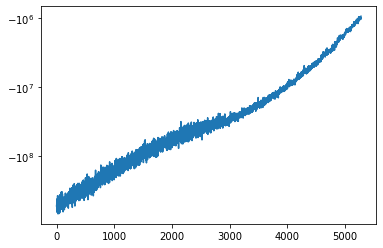

In [18]:
plt.plot(lower_bounds)
plt.yscale('symlog')

In [ ]:
len(mu_ts)

In [ ]:
mu_va = np.mean(np.array(mu_ts)[8900:,:,:], axis = 0)
d_va = np.mean(np.array(d_ts)[8900:,:,:], axis = 0)
B_va = np.mean(np.array(B_ts)[8900:,:,:], axis = 0)
var_va = np.sqrt(np.diag(B_va.dot(B_va.T) + np.diag(d_va**2)))

In [ ]:
all_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_new_77.npy')

In [ ]:
len(all_thetas)

In [ ]:
mu_mcmc = np.mean(all_thetas[3000:,:], axis= 0)
mu_sd = np.std(all_thetas[3000:,:], axis= 0)

In [ ]:
plt.scatter(mu_va[0:10], mu_mcmc[0:10], color = 'b')
plt.scatter(mu_va[10:20], mu_mcmc[10:20], color = 'r')
plt.scatter(mu_va[20], mu_mcmc[20], color = 'g')
ident = [-9,3]
plt.plot(ident, ident)

In [ ]:
plt.scatter(var_va[0:10], mu_sd[0:10], color = 'b')
plt.scatter(var_va[10:20], mu_sd[10:20], color = 'r')
plt.scatter(var_va[20], mu_sd[20], color = 'g')
ident = [0,.6]
plt.plot(ident, ident)